# Forecast the CocaCola prices and Airlines Passengers data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

## Data irlines Passengers

In [2]:
Airline = pd.read_excel("Airlines+Data.xlsx")
Airline

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


<AxesSubplot:>

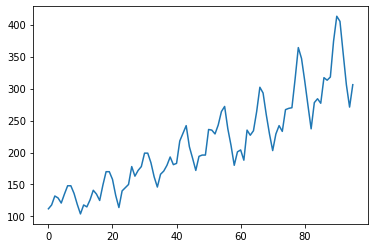

In [3]:
Airline.Passengers.plot()

In [4]:
len(Airline['Passengers'])

96

In [5]:
0.9*96

86.4

In [6]:
0.1*96

9.600000000000001

# Splitting data

In [7]:
Train = Airline.head(86)
Test = Airline.tail(10)

# Moving Average 

In [8]:
list(range(2,24,6))

[2, 8, 14, 20]

In [9]:
Airline.columns

Index(['Month', 'Passengers'], dtype='object')

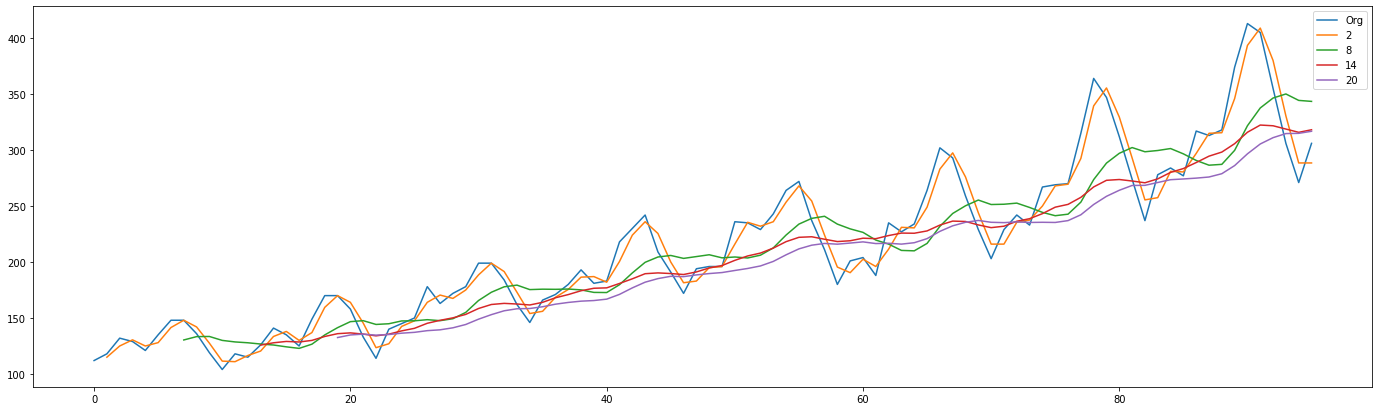

In [10]:
plt.figure(figsize=(24,7))
Airline.Passengers.plot(label="Org")
for i in range(2,24,6):
    Airline["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')
plt.show()

# Time series decomposition plot 


C:\Users\DELL\AppData\Local\Temp/ipykernel_2068/2775899791.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decompose_ts_add = seasonal_decompose(Airline.Passengers,freq= 12)


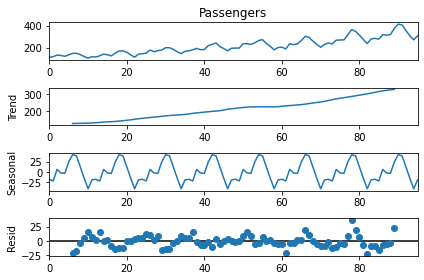

In [11]:
decompose_ts_add = seasonal_decompose(Airline.Passengers,freq= 12)
decompose_ts_add.plot()
plt.show()

# ACF plots and PACF plots


A partial autocorrelation (PACF) is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

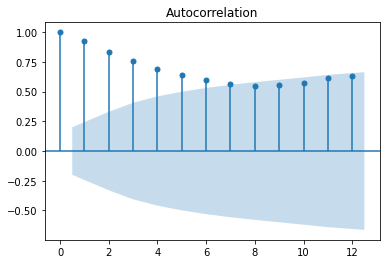

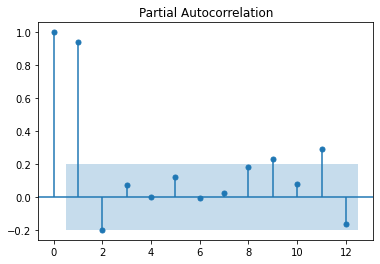

In [12]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(Airline.Passengers,lags=12)
tsa_plots.plot_pacf(Airline.Passengers,lags=12)
plt.show()

### Evaluation Metric MAPE

In [13]:
#Mean Absolute Percentage Error
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [14]:
#Weighted Moving Average
import pandas as pd
import numpy as np 
df = pd.DataFrame({'X':range(100,30, -5)})
weights = np.array([0.1, 0.2, 0.3, 0.4])
df['MA'] = df['X'].rolling(4).apply(lambda x: np.sum(weights*x))
df

,X,MA
0,100,NaN
1,95,NaN
2,90,NaN
3,85,90.0
4,80,85.0
5,75,80.0
6,70,75.0
7,65,70.0
8,60,65.0
9,55,60.0


In [15]:
df=pd.DataFrame()
df['Passengers']=Airline["Passengers"]
df['PSNGR'] = df['Passengers'].rolling(4).apply(lambda x: np.sum(weights*x))
df

,Passengers,PSNGR
0,112,NaN
1,118,NaN
2,132,NaN
3,129,126.0
4,121,125.3
...,...,...
91,405,392.5
92,355,383.5
93,306,351.2
94,271,311.7


### Simple Exponential Method


In [16]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Passengers) 

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


16.027027959160037

### Holt method 

In [17]:
# Holt method 
hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Passengers) 

C:\Users\DELL\AppData\Local\Temp/ipykernel_2068/2579047746.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)


18.350703666684698

### Holts winter exponential smoothing with additive seasonality and additive trend


In [18]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",
                                         seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Passengers) 

7.681164643204111

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [19]:
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",
                                         seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Passengers)

3.3287407055478773

## Final Model by combining train and test

In [20]:
hwe_model_add_add = ExponentialSmoothing(Airline["Passengers"],seasonal="add",trend="add",
                                         seasonal_periods=12).fit()

In [21]:
#Forecasting for next 10 time periods
hwe_model_add_add.forecast(10)

96     319.235171
97     311.528270
98     350.278564
99     346.984856
100    351.844892
101    403.925507
102    440.566528
103    427.446111
104    376.627761
105    329.767093
dtype: float64

# ARIMA MODEL

In [22]:
Arm_Airlines = pd.read_excel('Airlines+Data.xlsx', 
                  header=0, index_col=0, parse_dates=True)

In [23]:
Arm_Airlines

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


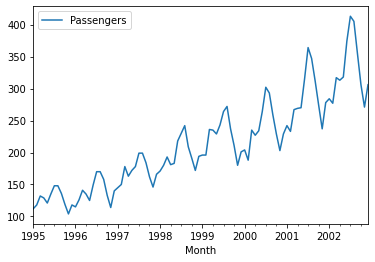

In [24]:
# line plot of time series
Arm_Airlines.plot()
plt.show()

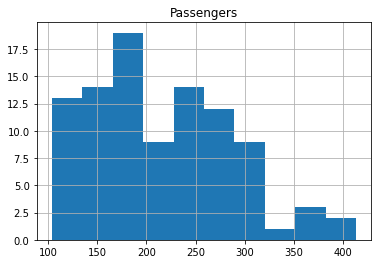

In [25]:
Arm_Airlines.hist()
plt.show()

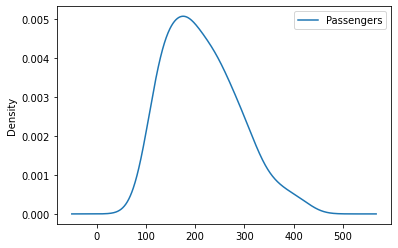

In [26]:
Arm_Airlines.plot(kind='kde')
plt.show()

In [27]:
len(Arm_Airlines)
#Oldest 86 values to be taken as training dataset
#Latest 10 values to be taken as test/validation dataset

96

In [28]:
# separate out a validation dataset
split_point = len(Arm_Airlines) - 10
dataset, validation = Arm_Airlines[0:split_point], Arm_Airlines[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 86, Validation 10


#### Persistence/ Base model

In [30]:
# evaluate a persistence model
from sklearn.metrics import mean_squared_error
# load data
train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [31]:
import os
os.getcwd()

'D:\\datascience Excelr\\class docs and assignments\\Assignments\\In progress\\2 Forecasting'

In [32]:
X

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277.],
      dtype=float32)

In [33]:
print(len(train))
print(len(test))
print(len(validation))

43
43
10


In [34]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=230.000, Expected=242.000
>Predicted=242.000, Expected=209.000
>Predicted=209.000, Expected=191.000
>Predicted=191.000, Expected=172.000
>Predicted=172.000, Expected=194.000
>Predicted=194.000, Expected=196.000
>Predicted=196.000, Expected=196.000
>Predicted=196.000, Expected=236.000
>Predicted=236.000, Expected=235.000
>Predicted=235.000, Expected=229.000
>Predicted=229.000, Expected=243.000
>Predicted=243.000, Expected=264.000
>Predicted=264.000, Expected=272.000
>Predicted=272.000, Expected=237.000
>Predicted=237.000, Expected=211.000
>Predicted=211.000, Expected=180.000
>Predicted=180.000, Expected=201.000
>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>Predicted=259.000, Expected=229.000
>

NameError: name 'sqrt' is not defined

#### ARIMA Hyperparameters

In [35]:
# grid search ARIMA parameters for a time series
from statsmodels.tsa.arima_model import ARIMA
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

#### Grid search for p,d,q values

In [36]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [38]:
# load dataset
train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


#### Build Model based on the optimized values

In [39]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

In [40]:
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

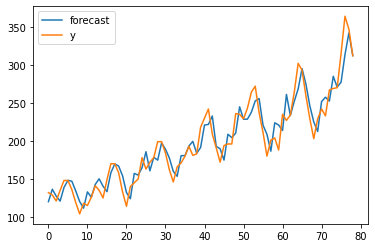

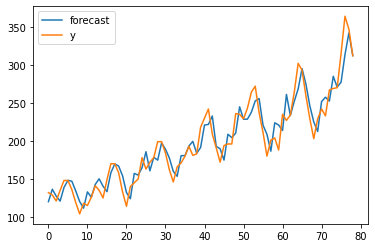

In [41]:
# fit model
model = ARIMA(X, order=(4,1,1))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1, 79)

In [43]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = np.sqrt(mean_squared_error(val[1], forecast))
rmse

56.19543269874655

#### Combine train and test data and build final model

In [44]:
# fit model
data = pd.read_excel('Airlines+Data.xlsx', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [45]:
model = ARIMA(X, order=(3,1,0))
model_fit = model.fit()

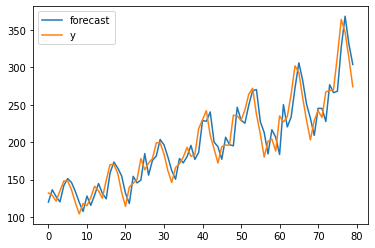

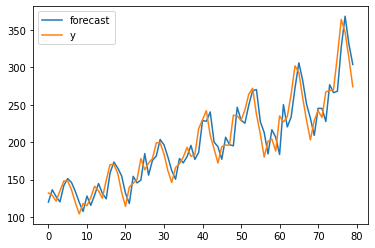

In [46]:
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1,80)

In [47]:
forecast

array([271.54443851, 272.96717287, 277.13673305, 280.43795446,
       282.22673782, 283.52403383, 285.09890711, 287.00429628,
       288.98785484, 290.89403638])

### CocaCola

In [48]:
CocoCola = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
CocoCola

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


<AxesSubplot:>

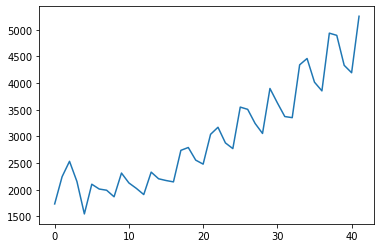

In [49]:
CocoCola.Sales.plot()

In [50]:
len(CocoCola['Sales'])

42

# Splitting data

In [51]:
Train = CocoCola.head(30)
Test = CocoCola.tail(12)

# Moving Average 

In [52]:
list(range(2,24,6))

[2, 8, 14, 20]

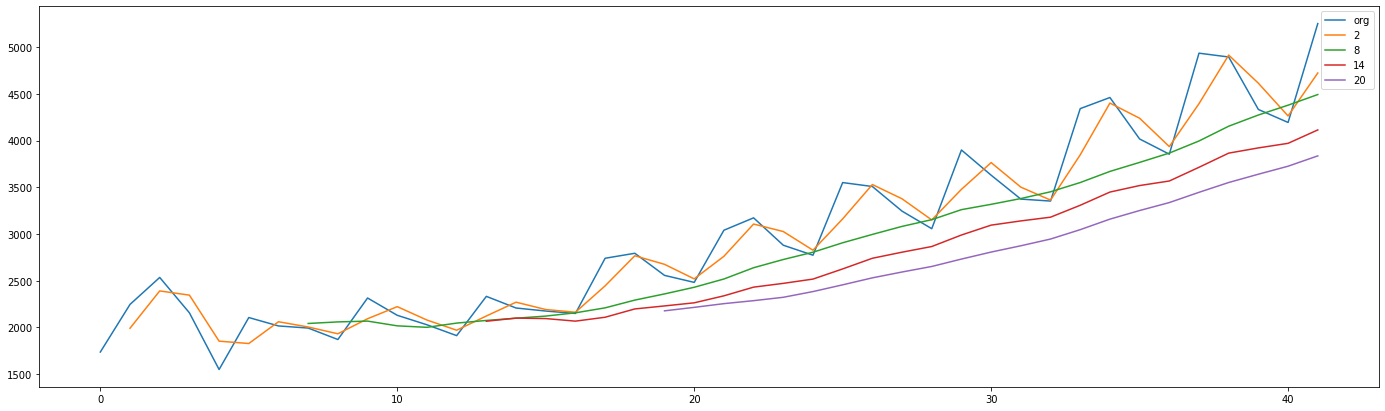

In [53]:
plt.figure(figsize=(24,7))
CocoCola.Sales.plot(label="org")
for i in range(2,24,6):
    CocoCola["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

# Time series decomposition plot 

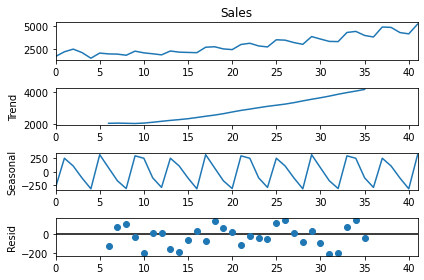

In [54]:
decompose_ts_add = seasonal_decompose(CocoCola.Sales,freq= 12)
decompose_ts_add.plot()
plt.show()

# ACF plots and PACF plots

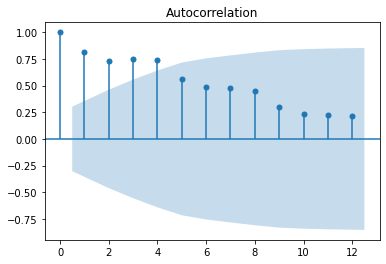

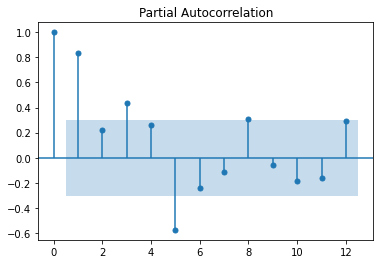

In [55]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(CocoCola.Sales,lags=12)
tsa_plots.plot_pacf(CocoCola.Sales,lags=12)
plt.show()

### Evaluation Metric MAPE

In [56]:
#Mean Absolute Percentage Error
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [57]:
#Weighted Moving Average
import pandas as pd
import numpy as np 
df = pd.DataFrame({'X':range(100,30, -5)})
weights = np.array([0.1, 0.2, 0.3, 0.4])
df['MA'] = df['X'].rolling(4).apply(lambda x: np.sum(weights*x))
df

,X,MA
0,100,NaN
1,95,NaN
2,90,NaN
3,85,90.0
4,80,85.0
5,75,80.0
6,70,75.0
7,65,70.0
8,60,65.0
9,55,60.0


In [58]:
df=pd.DataFrame()
df['Sales']=CocoCola["Sales"]
df['Sales_WMA'] = df['Sales'].rolling(4).apply(lambda x: np.sum(weights*x))
df

,Sales,Sales_WMA
0,1734.827000,NaN
1,2244.960999,NaN
2,2533.804993,NaN
3,2154.962997,2244.601596
4,1547.818996,1996.873596
5,2104.411995,1990.483596
6,2014.362999,1962.128897
7,1991.746998,1976.671997
8,1869.049999,1958.457898
9,2313.631996,2085.953498


### Simple Exponential Method

In [59]:
ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales) 

22.046763674416013

### Holt method 

In [60]:
# Holt method 
hw_model = Holt(Train["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales) 

11.213841813055117

### Holts winter exponential smoothing with additive seasonality and additive trend


In [61]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",
                                         seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales) 

8.414654273336852

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [62]:
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",
                                         seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales)

4.399566180786818

## Final Model by combining train and test

In [63]:
hwe_model_add_add = ExponentialSmoothing(CocoCola["Sales"],seasonal="add",trend="add",
                                         seasonal_periods=12).fit()

In [64]:
#Forecasting for next 10 time periods
hwe_model_add_add.forecast(10)

42    4978.008475
43    4833.797051
44    4859.150179
45    5651.294115
46    5683.506392
47    5344.712490
48    5244.558948
49    6092.417195
50    6036.553603
51    5696.439381
dtype: float64

# Arima Model

In [65]:
CocoCola_Arima = pd.read_excel('CocaCola_Sales_Rawdata.xlsx',header=0, index_col=0, parse_dates=True)

In [66]:
CocoCola_Arima

,Sales
Quarter,
Q1_86,1734.827000
Q2_86,2244.960999
Q3_86,2533.804993
Q4_86,2154.962997
Q1_87,1547.818996
Q2_87,2104.411995
Q3_87,2014.362999
Q4_87,1991.746998
Q1_88,1869.049999


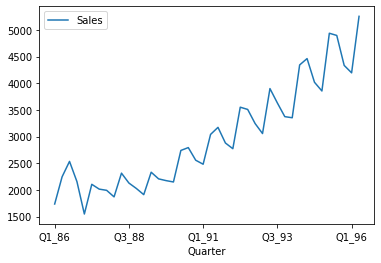

In [69]:
# line plot of time series
CocoCola_Arima.plot()
plt.show()

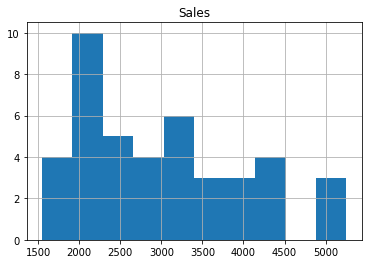

In [70]:
CocoCola_Arima.hist()
plt.show()

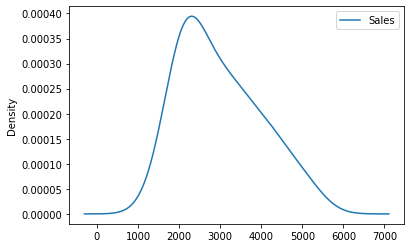

In [71]:
CocoCola_Arima.plot(kind='kde')
plt.show()

In [72]:
len(CocoCola_Arima)
#Oldest 32 values to be taken as training dataset
#Latest 10 values to be taken as test/validation dataset

42

In [73]:
# separate out a validation dataset
split_point = len(CocoCola_Arima) - 10
dataset, validation = CocoCola_Arima[0:split_point], CocoCola_Arima[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset_cocacola.csv', header=False)
validation.to_csv('validation_cocacola.csv', header=False)

Dataset 32, Validation 10


#### Persistence/ Base model

In [74]:
# evaluate a persistence model
from sklearn.metrics import mean_squared_error
# load data
train = read_csv('dataset_cocacola.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [75]:
import os
os.getcwd()

'D:\\datascience Excelr\\class docs and assignments\\Assignments\\In progress\\2 Forecasting'

In [76]:
X

array([1734.827 , 2244.961 , 2533.805 , 2154.963 , 1547.819 , 2104.412 ,
       2014.363 , 1991.747 , 1869.05  , 2313.632 , 2128.32  , 2026.829 ,
       1910.604 , 2331.165 , 2206.55  , 2173.968 , 2148.278 , 2739.308 ,
       2792.754 , 2556.01  , 2480.9739, 3039.523 , 3172.116 , 2879.001 ,
       2772.    , 3550.    , 3508.    , 3243.86  , 3056.    , 3899.    ,
       3629.    , 3373.    ], dtype=float32)

In [77]:
print(len(train))
print(len(test))
print(len(validation))

16
16
10


In [78]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=2173.968, Expected=2148.278
>Predicted=2148.278, Expected=2739.308
>Predicted=2739.308, Expected=2792.754
>Predicted=2792.754, Expected=2556.010
>Predicted=2556.010, Expected=2480.974
>Predicted=2480.974, Expected=3039.523
>Predicted=3039.523, Expected=3172.116
>Predicted=3172.116, Expected=2879.001
>Predicted=2879.001, Expected=2772.000
>Predicted=2772.000, Expected=3550.000
>Predicted=3550.000, Expected=3508.000
>Predicted=3508.000, Expected=3243.860
>Predicted=3243.860, Expected=3056.000
>Predicted=3056.000, Expected=3899.000
>Predicted=3899.000, Expected=3629.000
>Predicted=3629.000, Expected=3373.000


NameError: name 'sqrt' is not defined

#### ARIMA Hyperparameters

In [79]:
# grid search ARIMA parameters for a time series
from statsmodels.tsa.arima_model import ARIMA
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

#### Grid search for p,d,q values

In [80]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [81]:
# load dataset
train = read_csv('dataset_cocacola.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


#### Build Model based on the optimized values

In [82]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

In [83]:
# load data
train = read_csv('dataset_cocacola.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

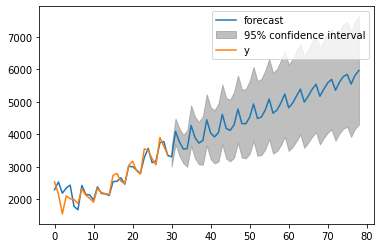

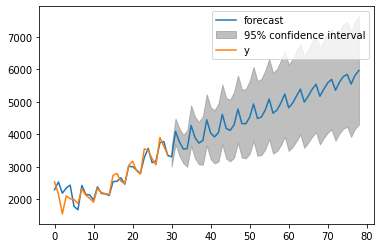

In [84]:
# fit model
model = ARIMA(X, order=(4,1,1))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1, 79)

In [86]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = np.sqrt(mean_squared_error(val[1], forecast))
rmse

3517.5019054775553

#### Combine train and test data and build final model

In [87]:
# fit model
data = pd.read_excel('CocaCola_Sales_Rawdata.xlsx',header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [88]:
model = ARIMA(X, order=(3,1,0))
model_fit = model.fit()

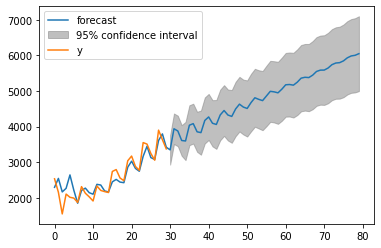

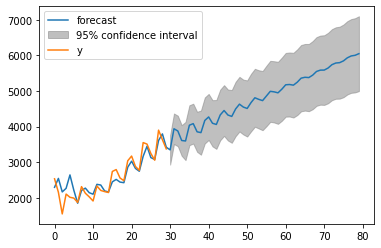

In [89]:
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1,80)

In [90]:
forecast

array([3345.57180156, 3938.30035827, 3875.95553888, 3608.81384559,
       3595.18231641, 4038.08319299, 4081.73248713, 3852.74069836,
       3829.94870386, 4171.48370036])